In [ ]:
import torch
from torch import nn
from torch import functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


## Data Exploration

### English Data

In [ ]:
data = pd.ExcelFile('/content/gdrive/My Drive/coursework/Ferguson-en.xlsx')
data = data.parse('Лист1')[['Text', 'sentiment']]
english = data[(data['sentiment'] != 'r') & (data['sentiment'] != 99) & (data['sentiment'] != 3)] 

In [ ]:
print('English Data')
english.head()

English Data


,Text,sentiment
0,@BougieBlackGurl We are asking the community f...,1
4,@Trouty20 #Ferguson Y must we die? Join Nat&#3...,2
5,@jimmykimmel #Ferguson Say nothing &amp; more ...,2
7,Protestors want to go to the police station. #...,0
8,Here with @MusicOverPeople and @brownblaze. Re...,0


In [ ]:
print('English classes')
english['sentiment'].value_counts()

English classes


2    1347
0     907
1     165
Name: sentiment, dtype: int64

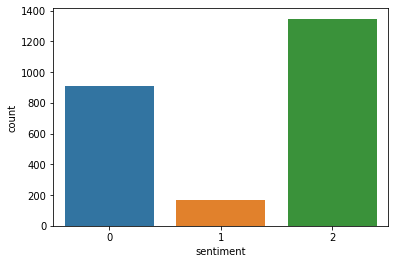

In [ ]:
sns.countplot(english.sentiment)

In [ ]:
english.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2419 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       2419 non-null   object
 1   sentiment  2419 non-null   object
dtypes: object(2)
memory usage: 136.7+ KB


### Russian Data

In [ ]:
russian = pd.read_json('/content/gdrive/My Drive/coursework/train.json')
russian = russian[['text', 'sentiment']]
russian['sentiment'] = russian['sentiment'].map({'neutral': 0, 'positive': 1, 'negative': 2}) 

In [ ]:
for i in range(len(russian['text'])):
  if len(russian['text'][i]) > 511:
    russian['text'][i] = russian['text'][i][:511]

In [ ]:
rus_1 = russian[russian['sentiment'] == 1][:1400]
rus_0 = russian[russian['sentiment'] == 0][:1400]
rus_2 = russian[russian['sentiment'] == 2][:1400]
russian = pd.concat([rus_1, rus_0])
russian = pd.concat([russian, rus_2])

In [ ]:
print('Russian Data')
russian.head()

Russian Data


,text,sentiment
15,Завод по переработке масличных культур построи...,1
17,АСТАНА. КАЗИНФОРМ - Средний показатель поездок...,1
18,который активно стимулирует казахстанских эксп...,1
19,Оплачивайте без комиссий «Казахтелеком» на сай...,1
20,"03.02.2017, 12:40\nНацбанк ставит для себя при...",1


In [ ]:
print('Russian classes')
russian['sentiment'].value_counts()

Russian classes


2    1400
1    1400
0    1400
Name: sentiment, dtype: int64

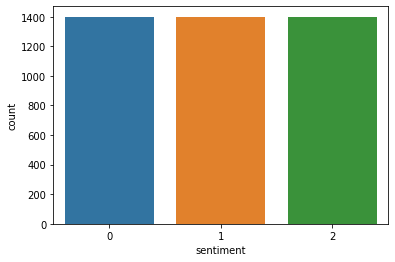

In [ ]:
sns.countplot(russian.sentiment)

In [ ]:
russian.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4200 entries, 15 to 8021
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       4200 non-null   object
 1   sentiment  4200 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 258.4+ KB


### Number of Features

In [ ]:
print('number of rows in table "english":', english.shape[0])
print('number of rows in table "russia":', russian.shape[0])

number of rows in table "english": 2419
number of rows in table "russia": 4200


## Data Preprocessing


### Data Cleaning 

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.metrics.scores import precision, recall, f_measure
lemmatizer = WordNetLemmatizer()

import re
from bs4 import BeautifulSoup

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def preprocess_text(text):
    text = BeautifulSoup(text).get_text()
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = text.lower().replace('ё', 'е')
    words = word_tokenize(text)
    lemma_words = [lemmatizer.lemmatize(i) for i in words]
    return lemma_words

def preprocess_for_lang(lang):
  if lang == 'english':
    text = [preprocess_text(t) for t in english['Text']]
    labels = pd.Series(np.array(english['sentiment']))

  else:
    text = [preprocess_text(t) for t in russian['text']]
    labels = pd.Series(np.array(russian['sentiment']))
    
  return pd.Series(text), labels

In [ ]:
eng_text, eng_labels = preprocess_for_lang('english')
rus_text, rus_labels = preprocess_for_lang('russia')

### Data Split and Balanced Classes

In [ ]:
rus_X_train, rus_X_test, rus_y_train, rus_y_test = train_test_split(rus_text, rus_labels, test_size = 0.2, random_state = 42)
rus_X_val, rus_X_test, rus_y_val, rus_y_test = train_test_split(rus_X_test, rus_y_test, test_size = 0.5, random_state = 42)

In [ ]:
def sampling():
  eng_X_train, eng_X_test, eng_y_train, eng_y_test = train_test_split(eng_text, eng_labels, test_size = 0.2, random_state = 42)
  eng_X_val, eng_X_test, eng_y_val, eng_y_test = train_test_split(eng_X_test, eng_y_test, test_size = 0.5, random_state = 42)

  data = pd.DataFrame({'data': eng_X_train, 'sent': eng_y_train})

  eng_X_train_1 = pd.concat([data[data['sent'] == 1], data[data['sent'] == 1]])
  eng_X_train_1 = pd.concat([eng_X_train_1, data[data['sent'] == 1]])
  eng_X_train_1 = pd.concat([eng_X_train_1, eng_X_train_1])
  data = pd.concat([data, eng_X_train_1])

  eng_X_train = data['data']
  eng_y_train = data['sent']

  data = pd.DataFrame({'data': pd.Series(eng_X_test), 'sent': pd.Series(eng_y_test)}) 
  eng_X_test = data['data']
  eng_y_test = data['sent']

  data = pd.DataFrame({'data': pd.Series(eng_X_val), 'sent': pd.Series(eng_y_val)}) 
  eng_X_val = data['data']
  eng_y_val = data['sent']
  
  return eng_X_train, eng_X_val, eng_X_test, eng_y_train, eng_y_val, eng_y_test

eng_X_train, eng_X_val, eng_X_test, eng_y_train, eng_y_val, eng_y_test = sampling()

### Data Vectorization

In [ ]:
!pip install transformers

import transformers as ppb

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model_bert = model_class.from_pretrained(pretrained_weights)


from transformers import DistilBertTokenizer, DistilBertModel

tokenizer_rus = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model_bert_rus = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

     |████████████████████████████████| 665kB 3.4MB/s 
     |████████████████████████████████| 890kB 48.4MB/s 
     |████████████████████████████████| 1.1MB 43.7MB/s 
     |████████████████████████████████| 3.8MB 45.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=61114fde598473c8d18e8ba92fe13c02af33c4e7e29c25146a8a5ce0c8d0f1b3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch

def text_to_hidden_states(tokenizer, model, X):

  tokenized = X.apply(lambda x: tokenizer.encode(x, add_special_tokens = True))
  max_len = 0

  for i in tokenized.values:
    if len(i) > max_len:
      max_len = len(i)

  padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

  attention_mask = torch.tensor(np.where(padded != 0, 1, 0))
  input_ids = torch.tensor(padded).to(torch.int64) 

  with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask = attention_mask)

  return last_hidden_states[0]

In [ ]:
def hidden(tokenizer, model, X_train, X_val, X_test, y_train, y_val, y_test):

  X_train = text_to_hidden_states(tokenizer, model, X_train)
  X_val = text_to_hidden_states(tokenizer, model, X_val)
  X_test = text_to_hidden_states(tokenizer, model, X_test)

  y_train = torch.from_numpy(np.array(y_train).astype(int))
  y_val = torch.from_numpy(np.array(y_val).astype(int))
  y_test = torch.from_numpy(np.array(y_test).astype(int))

  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
eng_X_train, eng_X_val, eng_X_test, eng_y_train, eng_y_val, eng_y_test = hidden(tokenizer, model_bert, 
                                                                                eng_X_train, eng_X_val, eng_X_test, eng_y_train, eng_y_val, eng_y_test)

In [ ]:
rus_X_train, rus_X_val, rus_X_test, rus_y_train, rus_y_val, rus_y_test = hidden(tokenizer_rus, model_bert_rus, 
                                                                                rus_X_train, rus_X_val, rus_X_test, rus_y_train, rus_y_val, rus_y_test)

## Model

In [ ]:
class CNNBaseline(nn.Module):
    def __init__(self, D, kernel_sizes, num_filters = 3):
        super(CNNBaseline, self).__init__()
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=D, out_channels=num_filters, kernel_size=K) for K in kernel_sizes])
        self.linear = nn.Linear(len(kernel_sizes) * num_filters, 3)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = [torch.nn.functional.relu(conv(x)) for conv in self.convs]
        x = [torch.nn.functional.max_pool1d(conv, conv.shape[2]) for conv in x] 
        x = torch.cat(x, dim=1).squeeze(2)

        out = self.linear(x)
        return out.squeeze()


kernel_sizes = [2] * 10 + [3] * 10 + [4] * 10 + [5] * 10
model = CNNBaseline(768, kernel_sizes)

loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## Train Model

In [ ]:
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X))
    for start_index in range(0, len(perm), batch_size):
        batch_indexes = perm[start_index:start_index + batch_size]
        X_batch = X[batch_indexes]
        y_batch = y[batch_indexes]
        yield X_batch, y_batch

In [ ]:
def train_epoch(model, X, y):
  model = model.train()
  losses = []
  correct_predictions = 0

  for X_batch, y_batch in batch_generator(X, y, 256):

    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    pred = model(X_batch)
    _, preds = torch.max(pred, dim=1)
    optimizer.zero_grad()
    loss = loss_fn(pred, y_batch)
    losses.append(loss.item())  
    loss.backward()
    optimizer.step()

    correct_predictions += torch.sum(preds == y_batch)
    
  return correct_predictions.double() / y.shape[0], np.mean(losses)

In [ ]:
def eval_model(model, X, y):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for X_batch, y_batch in batch_generator(X, y, 256):

      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      pred = model(X_batch)
      _, preds = torch.max(pred, dim=1)
      loss = loss_fn(pred, y_batch)
      losses.append(loss.item())

      correct_predictions += torch.sum(preds == y_batch)
      
  return correct_predictions.double() / y.shape[0], np.mean(losses)

In [ ]:
def train_model(mode, model, X_train, y_train, X_val, y_val, X_test, y_test, n_epoch):
  if mode == 'train':
    %%time
    history_train_loss = []
    history_val_loss = []
    history_train_acc = []
    history_val_acc = []
    best_accuracy = 0

    for epoch in range(n_epoch):
      '''print(f'Epoch {epoch + 1}/{n_epoch}')
      print('-' * 10)'''

      train_acc, train_loss = train_epoch(model, X_train, y_train)
      #print(f'Train loss {train_loss} accuracy {train_acc}')

      val_acc, val_loss = eval_model(model, X_val, y_val)
      '''print(f'Val   loss {val_loss} accuracy {val_acc}')
      print()'''

      history_train_acc.append(train_acc)
      history_train_loss.append(train_loss)
      history_val_acc.append(val_acc)
      history_val_loss.append(val_loss)

      if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

    print()
    print(f'Train loss {train_loss} accuracy {train_acc}')
    #print()
    print(f'Val   loss {val_loss} accuracy {val_acc}')

  else:
    test_acc, _ = eval_model(model, X_test, y_test)
    print(test_acc.item())

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

CNN_eng = model.to(device)
CNN_rus = model.to(device)

In [ ]:
print('English Train')
print()
train_model('train', CNN_eng, eng_X_train, eng_y_train, eng_X_val, eng_y_val, eng_X_test, eng_y_test, 30)

English Train

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs

Train loss 0.015220655043694105 accuracy 0.9985267034990791
Val   loss 0.914513111114502 accuracy 0.7603305785123967


In [ ]:
print('English Test')
train_model('test', CNN_eng, eng_X_train, eng_y_train, eng_X_val, eng_y_val, eng_X_test, eng_y_test, 0)

English Test
0.7809917355371901


In [ ]:
print('Russian Train')
print()
train_model('train', CNN_rus, rus_X_train, rus_y_train, rus_X_val, rus_y_val, rus_X_test, rus_y_test, 30)

Russian Train

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs

Train loss 0.11424087121018342 accuracy 0.9788690476190477
Val   loss 1.1435400247573853 accuracy 0.5714285714285715


In [ ]:
print('Russian Test')
train_model('test', CNN_rus, rus_X_train, rus_y_train, rus_X_val, rus_y_val, rus_X_test, rus_y_test, 0)

Russian Test
0.5523809523809524


## Evaluation 

In [ ]:
def get_predictions(model, X, y):
  model = model.eval()
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for X_batch, y_batch in batch_generator(X, y, 256):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      pred = model(X_batch)
      _, preds = torch.max(pred, dim=1)

      probs = torch.nn.functional.softmax(pred, dim=1)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(y_batch)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return predictions, prediction_probs, real_values

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def report(model, X_test, y_test):
  y_pred, y_pred_probs, y_test = get_predictions(model, X_test, y_test)
  class_names = ['neutral', 'positive', 'negative']
  return classification_report(y_test, y_pred, target_names=class_names), y_test, y_pred

In [ ]:
rep_eng, y_test_eng, y_pred_eng = report(CNN_eng, eng_X_test, eng_y_test)
print('English Report')
print(rep_eng)

English Report
              precision    recall  f1-score   support

     neutral       0.88      0.60      0.71        85
    positive       0.67      0.33      0.44        18
    negative       0.76      0.96      0.85       139

    accuracy                           0.79       242
   macro avg       0.77      0.63      0.67       242
weighted avg       0.79      0.79      0.77       242



In [ ]:
rep_rus, y_test_rus, y_pred_rus = report(CNN_rus, rus_X_test, rus_y_test)
print('Russian Report')
print(rep_rus)

Russian Report
              precision    recall  f1-score   support

     neutral       0.47      0.44      0.45       144
    positive       0.64      0.57      0.60       155
    negative       0.55      0.67      0.60       121

    accuracy                           0.55       420
   macro avg       0.55      0.56      0.55       420
weighted avg       0.55      0.55      0.55       420



In [ ]:
import seaborn as sns

class_names = ['neutral', 'positive', 'negative']

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

def conf_matr_lang(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
  show_confusion_matrix(df_cm)

English Matrix



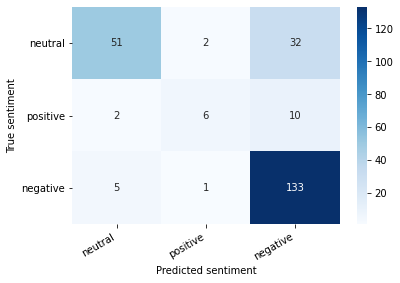

In [ ]:
print('English Matrix')
print()
conf_matr_lang(y_test_eng, y_pred_eng)

Russian Matrix



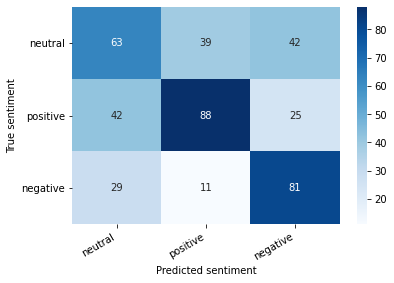

In [ ]:
print('Russian Matrix')
print()
conf_matr_lang(y_test_rus, y_pred_rus)

## Predicting on Raw Text

In [ ]:
def predict_for_new(review_text, tokenizer, model_bert, CNN):
  
  for text in review_text:
    encoded_review = tokenizer.encode_plus(text, max_length=100, add_special_tokens=True, return_token_type_ids=False, 
                                        pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')

    input_ids = encoded_review['input_ids']
    attention_mask = encoded_review['attention_mask']
    with torch.no_grad():
      last_hidden_states = model_bert(input_ids, attention_mask = attention_mask)

    output = CNN(last_hidden_states[0].to(device))
    _, prediction = torch.max(output.unsqueeze(0), dim=1)
    
    print(f'Review text: {text}')
    print(f'Sentiment  : {class_names[prediction]}')
    print()

In [ ]:
print('English Predict')
print()
text_eng = ['it was the most terrible camera in my life!', 
            'I love completing my todos! Best app ever!!!', 
            'The best movie I’ve ever seen!!! Musical composition, actors, scenario, etc. all this stuff are just amazing!!!',
            'This film made me upset. It’s just taking your free time and throwing it in a trash (((',
            'ipone is a phone']

predict_for_new(text_eng, tokenizer, model_bert, CNN_eng)

English Predict

Review text: it was the most terrible camera in my life!
Sentiment  : negative

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive

Review text: The best movie I’ve ever seen!!! Musical composition, actors, scenario, etc. all this stuff are just amazing!!!
Sentiment  : positive

Review text: This film made me upset. It’s just taking your free time and throwing it in a trash (((
Sentiment  : negative

Review text: ipone is a phone
Sentiment  : neutral



In [ ]:
print('Russian Predict')
text_rus = ['Ого... Отличное место.', 
            'это качественный телефон?', 
            'худший фильм который я видела',
            'ужасное качество фотографий!',
            'Корочка так себе.']

predict_for_new(text_rus, tokenizer_rus, model_bert_rus, CNN_rus)

Russian Predict
Review text: Ого... Отличное место.
Sentiment  : negative

Review text: это качественный телефон?
Sentiment  : negative

Review text: худший фильм который я видела
Sentiment  : negative

Review text: ужасное качество фотографий!
Sentiment  : negative

Review text: Корочка так себе.
Sentiment  : negative



## Baseline Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
def report_baseline(X_train, y_train, X_test, y_test, model):

  if model == 'LogisticRegression':
    clf = LogisticRegression(multi_class = 'multinomial', random_state = 42)
    clf.fit(X_train[:, 0, :], y_train)

  elif model == 'RandomForestClassifier':
    clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
    clf.fit(X_train[:, 0, :], y_train)

  else:
    params_grid = [{'kernel': ['rbf'], 'gamma': 1e-3, 'C': 100}]

    clf = SVC(kernel = 'rbf', gamma = 1e-3, C = 100)
    clf.fit(X_train[:, 0, :], y_train)

  return classification_report(clf.predict(X_test[:, 0, :]), y_test)

### Logistic Regression

In [ ]:
print(report_baseline(eng_X_train, eng_y_train, eng_X_test, eng_y_test, 'LogisticRegression'))

              precision    recall  f1-score   support

           0       0.72      0.73      0.73        83
           1       0.56      0.45      0.50        22
           2       0.83      0.84      0.83       137

    accuracy                           0.77       242
   macro avg       0.70      0.68      0.69       242
weighted avg       0.77      0.77      0.77       242



In [ ]:
print(report_baseline(rus_X_train, rus_y_train, rus_X_test, rus_y_test, 'LogisticRegression'))

              precision    recall  f1-score   support

           0       0.38      0.45      0.42       121
           1       0.61      0.60      0.60       156
           2       0.64      0.55      0.59       143

    accuracy                           0.54       420
   macro avg       0.54      0.53      0.54       420
weighted avg       0.55      0.54      0.55       420



### Random Forest Classifier

In [ ]:
print(report_baseline(eng_X_train, eng_y_train, eng_X_test, eng_y_test, 'RandomForestClassifier'))

              precision    recall  f1-score   support

           0       0.69      0.66      0.68        89
           1       0.22      0.57      0.32         7
           2       0.81      0.77      0.79       146

    accuracy                           0.73       242
   macro avg       0.58      0.67      0.60       242
weighted avg       0.75      0.73      0.74       242



In [ ]:
print(report_baseline(rus_X_train, rus_y_train, rus_X_test, rus_y_test, 'RandomForestClassifier'))

              precision    recall  f1-score   support

           0       0.47      0.40      0.43       170
           1       0.35      0.48      0.41       115
           2       0.48      0.43      0.45       135

    accuracy                           0.43       420
   macro avg       0.44      0.44      0.43       420
weighted avg       0.44      0.43      0.43       420



### Support Vector Machine

In [ ]:
print(report_baseline(eng_X_train, eng_y_train, eng_X_test, eng_y_test, 'SVM'))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76        89
           1       0.56      0.43      0.49        23
           2       0.79      0.85      0.82       130

    accuracy                           0.77       242
   macro avg       0.71      0.67      0.69       242
weighted avg       0.76      0.77      0.76       242



In [ ]:
print(report_baseline(rus_X_train, rus_y_train, rus_X_test, rus_y_test, 'SVM'))

              precision    recall  f1-score   support

           0       0.33      0.51      0.40        94
           1       0.63      0.60      0.61       162
           2       0.71      0.52      0.60       164

    accuracy                           0.55       420
   macro avg       0.56      0.54      0.54       420
weighted avg       0.59      0.55      0.56       420

